In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
data = pd.read_csv('cheap_train_sample.csv')
data.shape

(6513, 14)

In [18]:
submission_data = pd.read_csv('test_data.csv')
submission_data.shape

(16281, 13)

In [19]:
concat_test_train = pd.concat([data,submission_data])

# Set hours per week of `work-class` 
in  [ 'never worked' ,'without pay'] to 0.

In [20]:
Fil = (concat_test_train['workclass']==' Without-pay')|(concat_test_train['workclass']==' Never-worked'  )

In [21]:
concat_test_train.loc[Fil,['hours-per-week']] = 0

In [22]:
# concat_test_train.loc[Fil,['hours-per-week']] 

# Dummy Features

In [23]:
dumb_feats = ['workclass','marital-status','occupation','sex']
concat_test_train = pd.get_dummies(concat_test_train, 
               columns = dumb_feats, 
               drop_first=True
              )

In [24]:
# concat_test_train.head().T


# Drop Features

In [25]:
drop_feats = ['fnlwgt', 'education',
              'relationship', #'capital-gain','capital-loss',
              'native-country',
             ]

concat_test_train.drop(columns=drop_feats, inplace = True)

# Binarize Target Feature

In [26]:
concat_test_train['wage'] = concat_test_train['wage'].replace({' <=50K':0, ' >50K':1})

# Re-Split data and submission data

In [27]:
data = concat_test_train.iloc[:len(data),:] #dummied, dropped
submission_data = concat_test_train.iloc[len(data):] # dummied, dropped

# Upsample under 50k in data

In [28]:
# examine class balance
data['wage'].value_counts(), data['wage'].value_counts(normalize=True)

(0.0    4945
 1.0    1568
 Name: wage, dtype: int64,
 0.0    0.759251
 1.0    0.240749
 Name: wage, dtype: float64)

In [29]:
from sklearn.utils import resample

# rows with wage = 0 (75%)
A = data[ data['wage'] == 0]

#rows with wage =1 (25%)
B = data[data['wage'] == 1]

#augment B to have the same number of rows as A
B_aug = resample(B, 
                replace = True,
                n_samples = len(A),
                 random_state = 14
                )

data_balanced = pd.concat([A,B_aug] )
data_balanced['wage'].value_counts()

0.0    4945
1.0    4945
Name: wage, dtype: int64

# Create X and Y 

In [30]:
X = data_balanced.drop(columns = ['wage'])
y = data_balanced['wage']

In [31]:
X_sub = submission_data.drop(columns = ['wage'])
# y_test will be predicted. 

In [32]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=8,shuffle=True ,stratify=y)

# Models

**Plan**: Grid search for each model type, then stack.


In [34]:
import time 
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

### Logistic Regression

In [35]:
from sklearn.linear_model import LogisticRegression

pipe_logreg = Pipeline([
    ('ss',StandardScaler()),
    ('logreg',LogisticRegression(penalty='l2' , max_iter=10**5) )
     ])

grid_logreg = {
    'logreg__penalty': ['l2','none'],
}
gs_logreg = GridSearchCV(pipe_logreg, 
                         param_grid= grid_logreg,
                        )

gs_logreg.fit(X_train,y_train)

print(f'Train score: {gs_logreg.score(X_train,y_train)}')
print(f'Test score: {gs_logreg.score(X_test,y_test)}')
gs_logreg.best_score_, gs_logreg.best_params_ 

Train score: 0.8120533908588378
Test score: 0.8111605337646584


(0.8073380613711916, {'logreg__penalty': 'l2'})

In [36]:
# pipe_logreg.get_params()


### kNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

pipe_knn = Pipeline([
    ('ss',StandardScaler()),
    ('knn' , KNeighborsClassifier(n_neighbors=10,weights='uniform') )
])

grid_knn = {'knn__n_neighbors':[8,9,10,11,12],
            'knn__weights': ['uniform','distance']
           }

gs_knn =GridSearchCV(pipe_knn,
                    param_grid=grid_knn)

gs_knn.fit(X_train, y_train)
print(f'Train score: {gs_knn.score(X_train,y_train)}')
print(f'Test score: {gs_knn.score(X_test,y_test)}')

gs_knn.best_score_ , gs_knn.best_params_

Train score: 0.9897532695159769
Test score: 0.8811160533764658


(0.8682759504392095, {'knn__n_neighbors': 8, 'knn__weights': 'distance'})

### Decision Tree

In [39]:
from sklearn.tree import DecisionTreeClassifier


pipe_dtc = Pipeline([
    ('ss',StandardScaler()),
    ('dtc',DecisionTreeClassifier(max_depth=5,min_samples_split=5) )
     ])

grid_dtc = {
    'dtc__max_depth': [None,1,5,10,15], 
    'dtc__min_samples_split': [5,6,7,8],
}
gs_dtc = GridSearchCV(pipe_dtc, 
                         param_grid= grid_dtc,
                        )
gs_dtc.fit(X_train,y_train)
print(f'Train score: {gs_dtc.score(X_train,y_train)}')
print(f'Test score: {gs_dtc.score(X_test,y_test)}')

gs_dtc.best_score_, gs_dtc.best_params_


Train score: 0.9664284751247135
Test score: 0.8944601698342095


(0.8627494351981941, {'dtc__max_depth': None, 'dtc__min_samples_split': 6})

In [40]:
# pipe_dtc.get_params()

### Bagging Trees

In [41]:
from sklearn.ensemble import BaggingClassifier

pipe_btc = Pipeline([
    ('ss',StandardScaler()),
    ('btc',BaggingClassifier(n_estimators=150) )
     ])

grid_btc = {
    'btc__n_estimators': [150],
#     'btc__max_depth': [None,1,5,10,15], 
#     'btc__min_samples_split': [5,6,7,8],
}
gs_btc = GridSearchCV(pipe_btc, 
                         param_grid= grid_btc,
                        )
gs_btc.fit(X_train,y_train)
print(f'Train score: {gs_btc.score(X_train,y_train)}')
print(f'Test score: {gs_btc.score(X_test,y_test)}')

gs_btc.best_score_, gs_btc.best_params_

Train score: 0.9897532695159769
Test score: 0.9187221997573797


(0.8921402126163003, {'btc__n_estimators': 150})

In [42]:
# pipe_btc.get_params()

### Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier
# rfc = RandomForestClassifier()

pipe_rfc = Pipeline([
    ('ss',StandardScaler()),
    ('rfc',RandomForestClassifier(max_depth=10, n_estimators=200) )
     ])

grid_rfc = {
    'rfc__n_estimators': [100,150,200],
    'rfc__max_depth': [6,8,10,12,14,16],
}
gs_rfc = GridSearchCV(pipe_rfc, 
                         param_grid= grid_rfc,
                        )
gs_rfc.fit(X_train,y_train)
print(f'Train score: {gs_rfc.score(X_train,y_train)}')
print(f'Test score: {gs_rfc.score(X_test,y_test)}')

gs_rfc.best_score_, gs_rfc.best_params_ #cvs.832 {'rfc__max_depth': 10, 'rfc__n_estimators': 200})


Train score: 0.9371713630848052
Test score: 0.8936514355034372


(0.8868829665226565, {'rfc__max_depth': 16, 'rfc__n_estimators': 200})

In [44]:
# pipe_rfc.get_params()

### AdaBoost Logreg

In [45]:
from sklearn.ensemble import AdaBoostClassifier
# ada_logreg = AdaBoostClassifier(base_estimator=LogisticRegression())

pipe_ada_logreg = Pipeline([
    ('ss',StandardScaler()),
    ('ada_logreg', AdaBoostClassifier(base_estimator=LogisticRegression(),
                                      learning_rate=1.1,n_estimators = 10),
    )
     ])

grid_ada_logreg = {
'ada_logreg__learning_rate': [0.9,1.0,1.1],
 'ada_logreg__n_estimators': [10,50,100],
}
gs_ada_logreg = GridSearchCV(pipe_ada_logreg, 
                         param_grid= grid_ada_logreg,
                        )
gs_ada_logreg.fit(X_train,y_train)
print(f'Train score: {gs_ada_logreg.score(X_train,y_train)}')
print(f'Test score: {gs_ada_logreg.score(X_test,y_test)}')

gs_ada_logreg.best_score_, gs_ada_logreg.best_params_ # 0.8296472557343492

Train score: 0.805446946204665
Test score: 0.8091386979377274


(0.8047756878040978,
 {'ada_logreg__learning_rate': 0.9, 'ada_logreg__n_estimators': 100})

In [46]:
# pipe_ada_logreg.get_params()

### AdaBoost Decision Tree

In [47]:
from sklearn.ensemble import AdaBoostClassifier
# ada_tree = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())
pipe_ada_tree = Pipeline([
    ('ss',StandardScaler()),
    ('ada_tree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate =0.9,n_estimators=100) )
     ])

grid_ada_tree = {
'ada_tree__learning_rate': [0.9,1.0,1.1],
 'ada_tree__n_estimators': [10,50,100],
}
gs_ada_tree = GridSearchCV(pipe_ada_tree, 
                         param_grid= grid_ada_tree,
                        )
gs_ada_tree.fit(X_train,y_train)
print(f'Train score: {gs_ada_tree.score(X_train,y_train)}')
print(f'Test score: {gs_ada_tree.score(X_test,y_test)}')

gs_ada_tree.best_score_, gs_ada_tree.best_params_


Train score: 0.9897532695159769
Test score: 0.9260008087343308


(0.8991514795717139,
 {'ada_tree__learning_rate': 1.0, 'ada_tree__n_estimators': 10})

# Stack the best model from each model class

In [48]:
from sklearn.ensemble import StackingClassifier

In [54]:
level1_models = [
#     ('pipe_logreg', Pipeline([
#             ('ss',StandardScaler()),
#             ('logreg',LogisticRegression(penalty='l2' , max_iter=10**5) )])
#             ), #end pipe_logreg
    ('pipe_knn', Pipeline([
        ('ss',StandardScaler()),
        ('knn' , KNeighborsClassifier(n_neighbors=10,weights='uniform') )] )
            ), # end pipe_knn
    ('pipe_dtc' , Pipeline([
        ('ss',StandardScaler()),
        ('dtc',DecisionTreeClassifier(max_depth=5) )])
            ), # end pipe_dtc
    ('pipe_btc',Pipeline([
        ('ss',StandardScaler()),
        ('btc',BaggingClassifier(n_estimators=150) )
         ])
            ), #end bag
    ('pipe_rfc', Pipeline([
        ('ss',StandardScaler()),
        ('rfc',RandomForestClassifier(max_depth=10, n_estimators=200) )
         ])
            ), # end rfc 
#     ('pipe_ada_logreg' , Pipeline([
#         ('ss',StandardScaler()),
#         ('ada_logreg', AdaBoostClassifier(base_estimator=LogisticRegression(),
#                                             learning_rate=1.1, n_estimators = 10))
#          ])
#         ), #end adalog
    ('pipe_ada_tree' , Pipeline([
        ('ss',StandardScaler()),
        ('ada_tree', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),learning_rate =0.9,n_estimators=100) )
         ]) #end adatree
)
                ]
     

stack = StackingClassifier(estimators=level1_models,
                         final_estimator=LogisticRegression())

cross_val_score(stack,X_train, y_train).mean() #0.9010390899193557

0.9041392747635829

In [61]:
stack.fit(X_train,y_train);

In [62]:
stack.score(X_train,y_train), gs_rfc.score(X_train,y_train)

(0.9888094917082378, 0.9371713630848052)

In [63]:
stack.score(X_test,y_test),gs_rfc.score(X_test,y_test)

(0.9296401132228063, 0.8936514355034372)

In [72]:
submission_data.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            16271, 16272, 16273, 16274, 16275, 16276, 16277, 16278, 16279,
            16280],
           dtype='int64', length=16281)

In [81]:
#sub_d = submission_data.drop(columns=['wage'])

In [82]:
preds = stack.predict(submission_data.drop(columns=['wage']))
probs = stack.predict_proba(submission_data.drop(columns=['wage']))

In [88]:
submission = pd.DataFrame(index = submission_data.index, 
                          columns=['preds','wage'])
submission['preds'] = preds
submission['wage'] = probs

In [89]:
submission.to_csv('submission.csv', index=False)

In [90]:
submission.head(5)

,preds,wage
0,0.0,0.991916
1,0.0,0.960724
2,0.0,0.830154
3,1.0,0.094589
4,0.0,0.992076


# F1 scores

In [65]:
from sklearn.metrics import f1_score

In [66]:
f1_score(y_test,preds) 

0.9316575019638649

# Confusion Matrix 

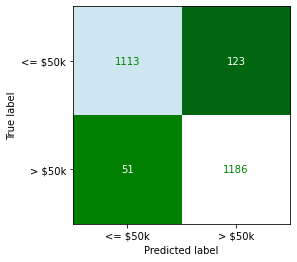

In [67]:
from sklearn.metrics import plot_confusion_matrix 

plot_confusion_matrix(stack, X_test,y_test, cmap='ocean', 
                      display_labels=['<= $50k','> $50k'],
                     colorbar=False); 

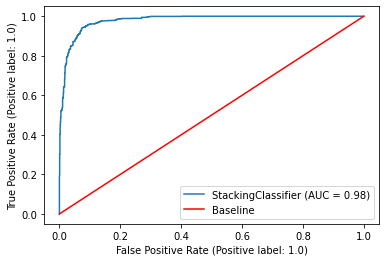

In [69]:
from sklearn import metrics
metrics.plot_roc_curve(stack, X_test,y_test)
plt.plot([0,1],[0,1], color='r', label='Baseline')
# add a legend
plt.legend();

In [70]:
probs = stack.predict_proba(X_test)[:,1]
metrics.roc_auc_score(y_test,probs)

0.9787426778954196

In [71]:
submission_data

probs

array([0.00751275, 0.01041139, 0.01013099, ..., 0.87191431, 0.96465201,
       0.90435881])

In [ ]:
probs.to_csv('probs.csv', index=False)